Dataloader

In [1]:
import os
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm

In [2]:
# Set kaggle API
!pip install --upgrade kaggle==1.7.4.2 --force-reinstall --no-deps
!mkdir /root/.kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [3]:
with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"","key":""}')

!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Download dataset
!mkdir '/content/data'
!kaggle datasets download -d nirmalsankalana/crop-pest-and-disease-detection -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/crop-pest-and-disease-detection
License(s): CC0-1.0


In [5]:
# DATAPATH
directory_path = "/content/data"

# LIST ALL FILE IN THE DIRECTORY
files = os.listdir(directory_path)

print(files)

['Cashew healthy', 'Tomato septoria leaf spot', 'Tomato leaf curl', 'Cashew gumosis', 'Cashew red rust', 'Cassava healthy', 'Cassava bacterial blight', 'Cashew leaf miner', 'Maize leaf blight', 'Tomato leaf blight', 'Cassava green mite', 'Cashew anthracnose', 'Maize healthy', 'Maize grasshoper', 'Maize leaf spot', 'Tomato verticulium wilt', 'Maize streak virus', 'Maize fall armyworm', 'Cassava mosaic', 'Cassava brown spot', 'Tomato healthy', 'Maize leaf beetle']


In [6]:
# ALL CATEGORIES LIST
categories = ['Tomato verticulium wilt', 'Cassava green mite', 'Cassava mosaic', 'Cashew red rust', 'Cashew gumosis',
              'Tomato healthy', 'Cassava brown spot', 'Cassava bacterial blight', 'Maize leaf beetle', 'Cassava healthy',
              'Maize leaf spot', 'Maize healthy', 'Tomato leaf blight', 'Cashew healthy', 'Cashew leaf miner',
              'Maize streak virus', 'Tomato septoria leaf spot', 'Maize leaf blight',
              'Cashew anthracnose', 'Tomato leaf curl', 'Maize fall armyworm']

# #LOOP THROUGH EACH CATEGORY AND DISPALY AN IMAGE
# for category in categories:
#     # DATAPATH
#     category_path = os.path.join("/content/data", category)

#     #LIST ALL FILES IN THE SUBDIRECTORY
#     files_in_category = os.listdir(category_path)

#     #CHOOSE THE 1ST FILE IN THE LIST
#     image_filename = files_in_category[0]

#     # CREATE THE FULL PATH TO THE IMAGE
#     image_path = os.path.join(category_path, image_filename)


#     img = mpimg.imread(image_path)

#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f'Category: {category}')
#     plt.show()

Processing 'Maize fall armyworm': 100%|██████████| 285/285 [00:00<00:00, 765.12it/s]


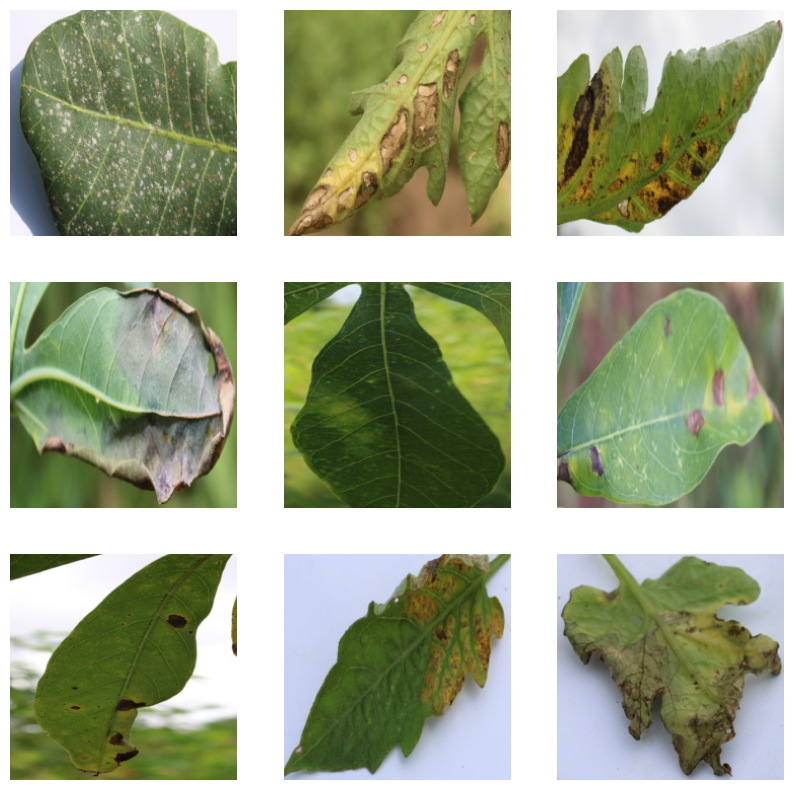

In [7]:
# Categories
categories = ['Tomato verticulium wilt', 'Cassava green mite', 'Cassava mosaic', 'Cashew red rust', 'Cashew gumosis',
              'Tomato healthy', 'Cassava brown spot', 'Cassava bacterial blight', 'Maize leaf beetle', 'Cassava healthy',
              'Maize leaf spot', 'Maize healthy', 'Tomato leaf blight', 'Cashew healthy', 'Cashew leaf miner',
              'Maize streak virus', 'Tomato septoria leaf spot', 'Maize leaf blight',
              'Cashew anthracnose', 'Tomato leaf curl', 'Maize fall armyworm']

# Set image path and labels
image_paths = []
image_labels = []

base_path = "/content/data"

for category in categories:
    category_dir = os.path.join(base_path, category)
    filenames = [f for f in os.listdir(category_dir) if f.endswith(".jpg")]
    for filename in tqdm(filenames, desc=f"Processing '{category}'"):
      image_path = os.path.join(category_dir, filename)
      try:
          img = Image.open(image_path)
          img = img.convert("RGB")
          img.load()  # load image each time to remove the damaged image thoroughly
          image_paths.append(image_path)
          image_labels.append(category)
      except (UnidentifiedImageError, OSError):
          continue

# Label encoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_labels)

# Dataset
class CropDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)), # To fit the pretrain model (说是resnet的官方推荐输入大小)
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # To fit the pretrain model (没有很懂啊，加上之后图片群魔乱舞)
])


# Make Dataset and DataLoader
dataset = CropDiseaseDataset(image_paths, encoded_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)

# Visualization
plt.figure(figsize=(10, 10))
for images, labels in dataloader:
    for i in range(9):
        img = images[i].permute(1, 2, 0).numpy()
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
    break
plt.show()

In [8]:
print(len(dataset))

24453


Feature extraction (ResNet18)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet
weights = ResNet18_Weights.DEFAULT
resnet18 = resnet18(weights=weights)

# Remove the final fully connected layer
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])
feature_extractor.to(device)
feature_extractor.eval()

# Extract features

def extract_features(dataloader, model, device):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            features = model(images)                  # shape: [B, 512, 1, 1]
            features = features.view(features.size(0), -1)  # flatten to [B, 512]
            all_features.append(features.cpu())
            all_labels.append(labels)

    return torch.cat(all_features), torch.cat(all_labels)

features, labels = extract_features(dataloader, feature_extractor, device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 223MB/s]
Extracting features: 100%|██████████| 96/96 [01:38<00:00,  1.03s/it]


In [10]:
# Results
print("Features shape:", features.shape)  # [N, 512]
print("Labels shape:", labels.shape)      # [N]

Features shape: torch.Size([24453, 512])
Labels shape: torch.Size([24453])


MC Dropout(not using feature extraction)

In [15]:
import random

In [13]:
def mc_dropout_inference(model, image, num_passes=20):
    """
    Perform inference on an input image using Monte Carlo dropout.

    Parameters:
        model: The YOLO (or any) model where dropout layers are active.
        image: A preprocessed input image tensor (e.g., shape [1, C, H, W]).
        num_passes: The number of stochastic forward passes to perform.

    Returns:
        mean_prediction: The average prediction across passes.
        uncertainty: The variance across passes as an uncertainty measure.
    """
    # Set model to training mode to activate dropout layers,
    # but keep BatchNorm layers in eval mode.
    model.train()
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()

    predictions = []
    with torch.no_grad():
        for _ in range(num_passes):
            pred = model(image)
            predictions.append(pred)

    preds_tensor = torch.stack(predictions)  # Shape: [num_passes, batch_size, ...]
    mean_prediction = preds_tensor.mean(dim=0)
    uncertainty = preds_tensor.var(dim=0)

    return mean_prediction, uncertainty

In [14]:
def select_uncertain_samples(unlabeled_images, model, num_passes=20, k=10):
    """
    Select the top-k most uncertain images from a set of unlabeled images using MC dropout.

    Parameters:
        unlabeled_images: List or iterable of image tensors.
        model: The trained YOLO model (with dropout layers) used for inference.
        num_passes: Number of stochastic forward passes for MC dropout.
        k: Number of most uncertain samples to select.

    Returns:
        selected_images: List of image tensors that are the most uncertain.
        uncertainty_scores: Numpy array of uncertainty scores for all images.
        selected_indices: Indices of the selected images in the unlabeled_images list.
    """
    uncertainty_scores = []
    for image in unlabeled_images:
        # Use MC dropout inference (we ignore the mean prediction here)
        _, uncertainty = mc_dropout_inference(model, image, num_passes=num_passes)
        # Compute a scalar uncertainty score; here, we use the mean of the uncertainty tensor.
        score = uncertainty.mean().item()
        uncertainty_scores.append(score)

    uncertainty_scores = np.array(uncertainty_scores)
    # Get the indices of the top-k most uncertain images.
    selected_indices = np.argsort(uncertainty_scores)[-k:]
    selected_images = [unlabeled_images[i] for i in selected_indices]

    return selected_images, uncertainty_scores, selected_indices

In [18]:
# 3. Simulate a Small Dataset for Testing Active Learning
# -------------------------

# Define the classes
classes = ["Tomato verticulium wilt", "Tomato healthy", "Tomato leaf blight"]

# Create a simulated unlabeled dataset with 5 images per class.
num_images_per_class = 5
unlabeled_dataset = []  # List of dictionaries: {"image": image_tensor, "label": label}
for label in classes:
    for _ in range(num_images_per_class):
        # Simulate an image tensor; shape is [1, 3, 224, 224].
        image = torch.rand((1, 3, 224, 224))
        unlabeled_dataset.append({"image": image, "label": label})

# Shuffle the dataset for randomness.
random.shuffle(unlabeled_dataset)

# Initialize the training dataset with one seed image per class.
training_dataset = []
for label in classes:
    for i, data in enumerate(unlabeled_dataset): # Use enumerate to get the index
        if data["label"] == label:
            training_dataset.append(data)
            # Remove using the index instead of the object directly
            del unlabeled_dataset[i]
            break

# Create a validation dataset by selecting 2 images per class from the unlabeled dataset.
validation_dataset = []
for label in classes:
    count = 0
    to_remove_indices = []  # Store indices to remove to avoid modifying the list while iterating
    for i, data in enumerate(unlabeled_dataset):
        if data["label"] == label and count < 2:
            validation_dataset.append(data)
            to_remove_indices.append(i)
            count += 1

    # Remove elements using indices in reverse order to avoid index shifting
    for index in sorted(to_remove_indices, reverse=True):
        del unlabeled_dataset[index]

In [19]:
# 4. Define Dummy Model, Training, and Evaluation Functions
# -------------------------

# Define a dummy YOLO-like model with dropout layers.
class DummyYOLO(nn.Module):
    def __init__(self):
        super(DummyYOLO, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 224 * 224, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, len(classes))
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # logits

# Initialize the dummy model.
model = DummyYOLO()

# Dummy retraining function (placeholder for actual training).
def retrain_yolo(model, training_dataset, epochs=1):
    """
    Simulate retraining the YOLO model on the training_dataset.

    In practice, you would update the model weights using your training loop.
    Here, we simply return the model unchanged.
    """
    # (Insert your training code here if needed.)
    return model

# Dummy evaluation function that simulates the model's performance.
def evaluate_model(model, validation_dataset):
    """
    Simulate model evaluation based on the size of the training dataset.

    For demonstration, we define performance as:
        performance = min(0.5 + 0.05 * (number of training images), 1.0)
    with a small random noise term.
    """
    performance = 0.5 + 0.05 * len(training_dataset)
    performance = min(performance, 1.0)
    performance += random.uniform(-0.02, 0.02)
    return performance

In [20]:
# 5. Active Learning Cycle
# -------------------------
num_active_cycles = 5           # Total number of active learning cycles to simulate.
selected_per_cycle = 2          # Number of samples to select at each cycle.
performance_history = []

for cycle in range(num_active_cycles):
    # Evaluate current performance on the validation dataset.
    performance = evaluate_model(model, validation_dataset)
    performance_history.append(performance)
    print(f"Cycle {cycle}: Model Performance (simulated accuracy) = {performance:.2f}")

    # If there are no more unlabeled images, break the loop.
    if len(unlabeled_dataset) == 0:
        print("No more unlabeled data.")
        break

    # Prepare a list of images from the unlabeled dataset for selection.
    images = [data["image"] for data in unlabeled_dataset]

    # Select the top-k most uncertain samples using MC dropout.
    selected_images, uncertainty_scores, selected_indices = select_uncertain_samples(
        images, model, num_passes=10, k=selected_per_cycle
    )

    print("Uncertainty scores for all unlabeled images:", uncertainty_scores)
    print("Selected indices:", selected_indices)

    # Retrieve the corresponding data (image and label) from the unlabeled dataset.
    selected_data = [unlabeled_dataset[i] for i in selected_indices]
    # Remove selected samples from the unlabeled dataset.
    for idx in sorted(selected_indices, reverse=True):
        unlabeled_dataset.pop(idx)

    # Add the selected samples to the training dataset.
    training_dataset.extend(selected_data)

    # Retrain the model using the updated training dataset (simulated).
    model = retrain_yolo(model, training_dataset, epochs=1)

Cycle 0: Model Performance (simulated accuracy) = 0.66
Uncertainty scores for all unlabeled images: [0.00346686 0.00166164 0.00257946 0.00401602 0.00194099 0.00235281]
Selected indices: [0 3]
Cycle 1: Model Performance (simulated accuracy) = 0.76
Uncertainty scores for all unlabeled images: [0.00257399 0.00328406 0.00223654 0.00383109]
Selected indices: [1 3]
Cycle 2: Model Performance (simulated accuracy) = 0.87
Uncertainty scores for all unlabeled images: [0.00312915 0.00272365]
Selected indices: [1 0]
Cycle 3: Model Performance (simulated accuracy) = 0.96
No more unlabeled data.


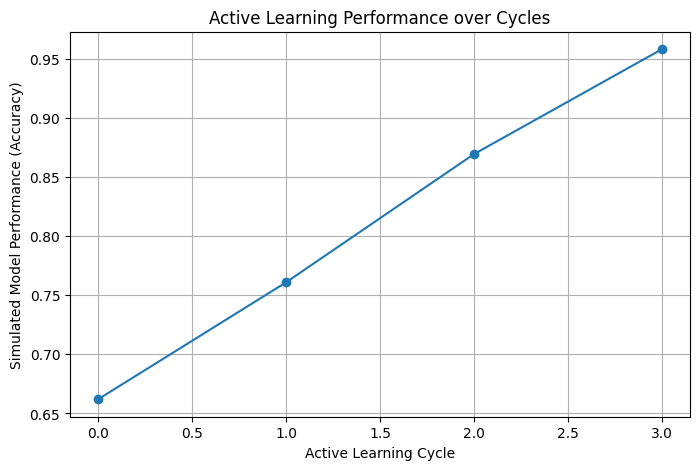

In [21]:
# 6. Plot the Performance Over Active Learning Cycles
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(len(performance_history)), performance_history, marker='o')
plt.xlabel("Active Learning Cycle")
plt.ylabel("Simulated Model Performance (Accuracy)")
plt.title("Active Learning Performance over Cycles")
plt.grid(True)
plt.show()

Density-Based Sampling(Using Feature Extraction)

Selected indices (top 5 samples): [21493 10101 21945 19940 14273]
Density scores for selected samples: [0.7512195  0.75134027 0.752857   0.7537568  0.7559162 ]


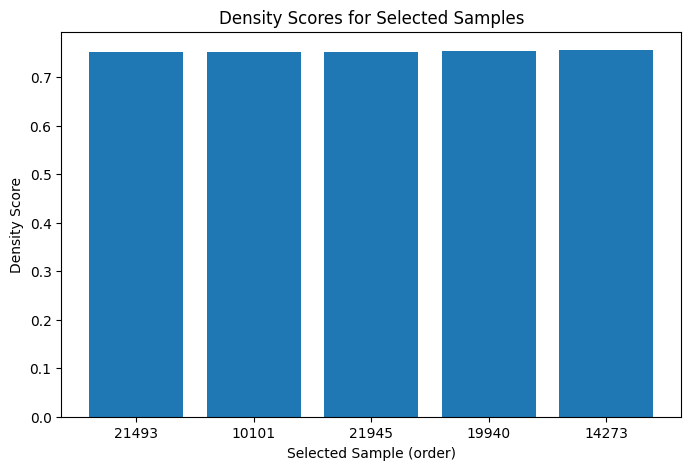

In [26]:
def select_density_samples_from_features(features, k=10):
    """
    Select the top-k samples based on density computed from pre-extracted features.

    Parameters:
        features: A NumPy array of shape (N, D), where N is the number of images
                  (e.g. 24453) and D is the feature dimension (e.g. 512).
        k: The number of samples to select.

    Returns:
        selected_indices: The indices of the selected samples (top-k with highest density).
        density_scores: A NumPy array of density scores for all samples.
    """
    # Normalize the feature vectors to unit length (to use cosine similarity)
    norms = np.linalg.norm(features, axis=1, keepdims=True) + 1e-8  # avoid division by zero
    norm_features = features / norms

    # Compute the pairwise cosine similarity matrix.
    # Note: Similarity between feature i and j is the dot product of normalized features.
    similarity_matrix = np.dot(norm_features, norm_features.T)

    # Remove self-similarity by setting the diagonal elements to 0.
    np.fill_diagonal(similarity_matrix, 0)

    # Compute density score for each image: here we take the average similarity
    density_scores = similarity_matrix.mean(axis=1)

    # Select the indices of the top-k samples with the highest density scores.
    selected_indices = np.argsort(density_scores)[-k:]

    return selected_indices, density_scores

# ------------------------------------------------------------------------------
# Test Code for Density-Based Sampling
# ------------------------------------------------------------------------------

# Here we assume that 'features' is already defined and has shape [24453, 512].
# For testing purposes, if 'features' is not defined, we'll simulate a smaller set.
try:
    features.shape
except NameError:
    # For demonstration only: simulate a smaller features array (e.g., 50 images).
    features = np.random.rand(50, 512)

# Choose the number of samples you want to select.
k = 5

# Call the density-based sampling function.
selected_indices, density_scores = select_density_samples_from_features(features, k)

print("Selected indices (top {} samples):".format(k), selected_indices)

# Extract the density scores for only the selected samples.
selected_density_scores = density_scores[selected_indices]

print("Density scores for selected samples:", selected_density_scores)

# Plot the density scores for the selected samples only.
plt.figure(figsize=(8, 5))
plt.bar(range(len(selected_density_scores)), selected_density_scores)
plt.xlabel("Selected Sample (order)")
plt.ylabel("Density Score")
plt.title("Density Scores for Selected Samples")
# Optionally, label the x-axis ticks with the actual indices from the dataset.
plt.xticks(range(len(selected_density_scores)), selected_indices)
plt.show()

In [27]:
print(density_scores)

[0.59213513 0.5815216  0.65492046 ... 0.7355523  0.72169185 0.6694779 ]
